In [11]:
import importlib
import models.marker_kernel
importlib.reload(models.marker_kernel)  # ✅ Force reload latest changes
from models.marker_kernel import MarkerAwareKernel

<module 'utils.training' from 'C:\\Users\\vaibh\\Downloads\\Kernel_Proj\\nsf-paper\\utils\\training.py'>

In [ ]:
import importlib
import models.sf
importlib.reload(models.sf)
import utils.training
importlib.reload(utils.training)
import tensorflow as tf
import tensorflow_probability as tfp
import scanpy as sc
import numpy as np
from sklearn.neighbors import NearestNeighbors
from models.sf import SpatialFactorization
from utils.training import ModelTrainer
from models.marker_kernel import MarkerAwareKernel
importlib.reload(models.marker_kernel)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from utils import benchmark

marker_genes = [
    "Slc17a7",  # Excitatory neurons
    "Gad1",     # Inhibitory neurons
    "Aqp4",     # Astrocytes
    "Pvalb",    # Parvalbumin interneurons
    "Sst",      # Somatostatin interneurons
    "Mog"       # Oligodendrocytes
]
scaler = StandardScaler()
adata = sc.read("C:/Users/vaibh/Downloads/Kernel_Proj/nsf-paper/scrna/visium_brain_sagittal/data/visium_brain_sagittal_J2000.h5ad")
marker_expr = adata[:, marker_genes].X.toarray()  # Convert to dense (N x K)
marker_expr = marker_expr.astype(np.float32)
spatial_coords = adata.obsm["spatial"]  # N x 2 matrix (x, y coordinates)
X_augmented = np.hstack([spatial_coords, marker_expr])  # N x (2 + K)
X_augmented = scaler.fit_transform(X_augmented).astype(np.float32)
#X_augmented = X_augmented.astype(np.float32)

def generate_marker_ml_pairs(marker_expr, n_neighbors=2):
    """Generate ML pairs using k-NN on marker expressions."""
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(marker_expr)
    _, indices = nbrs.kneighbors(marker_expr)
    ml_ind1 = np.repeat(np.arange(marker_expr.shape[0]), n_neighbors)
    ml_ind2 = indices.flatten()
    return ml_ind1, ml_ind2

ml_ind1, ml_ind2 = generate_marker_ml_pairs(marker_expr, n_neighbors=2)

idx = tf.range(X_augmented.shape[0])  # total N
dataset_dict = {
    "X": X_augmented,
    "Y": adata.X.toarray(),
    "sz": np.ones(X_augmented.shape[0], dtype=np.float32),
    "idx": idx
}

Dtrain = tf.data.Dataset.from_tensor_slices(dataset_dict).batch(256)

# Setup clustering-based inducing points
kmeans = KMeans(n_clusters=100, random_state=42).fit(X_augmented)
Z_init = kmeans.cluster_centers_.astype(np.float32)

# Generate subset indices for test
subset_indices = np.arange(256)

# 1. Generate the full mask once
N = marker_expr.shape[0]
ML_mask = np.zeros((N, N), dtype=bool)
for i, j in zip(ml_ind1, ml_ind2):
    ML_mask[i, j] = True
    ML_mask[j, i] = True  # Symmetric
ML_mask = tf.convert_to_tensor(ML_mask)
#kernel.must_link_mask = tf.constant(ML_mask, dtype=tf.bool)

# 2. Define kernel_fn with access to the global mask
def kernel_fn(amplitude):
    kernel = MarkerAwareKernel(spatial_dims=2, marker_dims=6, amplitude=amplitude, length_scale=0.1)
    kernel.full_must_link_mask = ML_mask

    # Subset mask just for init/plotting
    #kernel.set_mask_for_indices(np.arange(100))  # Use same indices as kernel eval
    return kernel

# Create and prepare kernel manually
kernel = kernel_fn(tf.constant(1.0))
kernel.full_must_link_mask = ML_mask
kernel.set_mask_for_indices(np.arange(256))# ✅ Apply subset mask now that kernel is defined

# Visualize kernel for debugging (optional)
K_test = kernel.matrix(X_augmented[subset_indices], X_augmented[subset_indices])
print("K_test shape:", K_test.shape)
print("Marker expression shape:", marker_expr.shape)

Z = X_augmented[:100]
Z_marker = Z[:, 2:]  # Assuming first 2 are spatial

ml_ind1, ml_ind2 = generate_marker_ml_pairs(Z_marker, n_neighbors=5)
full_mask = np.zeros((100, 100), dtype=bool)
full_mask[ml_ind1, ml_ind2] = True
full_mask[ml_ind2, ml_ind1] = True


# Initialize model with augmented dimensions
model = SpatialFactorization(
    J=adata.n_vars,
    L=10,
    Z=Z_init,
    ml_weight=1,
    nonneg=True,
    isotropic=False,
    marker_dim=marker_expr.shape[1],  # = 6
    psd_kernel=kernel_fn,
    nugget=1e-2
)
model.kernel.full_must_link_mask = tf.constant(full_mask)
# Set the global must-link constraints in the model
model.set_marker_constraints(ml_ind1, ml_ind2)
trainer = ModelTrainer(model, lr=0.01, pickle_path=None)
trainer_marker = trainer
print("SpatialFactorization model good")
trainer_marker.train_model(
    Dtrain=Dtrain,
    Ntr=adata.n_obs,
    num_epochs=1000,
    ckpt_freq=50,
    verbose=True
)

K_marker shape: [1 256 256]
Mask shape used: [256 256]
K_marker shape: [1 256 256]
Mask shape used: [256 256]
K_test shape: (1, 256, 256)
Marker expression shape: (2487, 6)
self.Omega_tril shape: [10 100 100]
K_marker shape: [1 10 100 100]
Mask shape used: [100 100]
K_marker shape: [1 10 100 100]
Mask shape used: [100 100]
Z shape: (100, 8)
SpatialFactorization model good
Temporary checkpoint directory: C:\Users\vaibh\AppData\Local\Temp\tmpp2ktns8d
X shape: (256, 8)
X shape: (256, 8)
Batch size: 256
K_marker shape: [1 10 100 100]
Mask shape: [100 100]
Mask shape used: [100 100]
Before train_step, mask shape: [100 100]
K_marker shape: [1 10 100 100]
Mask shape used: [100 100]
Kuu_chol shape: [10 100 100]
K_marker shape: [1 10 100 256]
Mask shape used: [100 100]
K_marker shape: [1 10 100 256]
Mask shape used: [100 100]
Kuf shape: [10 100 256]
K_marker shape: [1 10 256 256]
Mask shape used: [100 100]
K_marker shape: [1 10 256 256]
Mask shape used: [100 100]
alpha_x shape: [10 100 256]
Kff

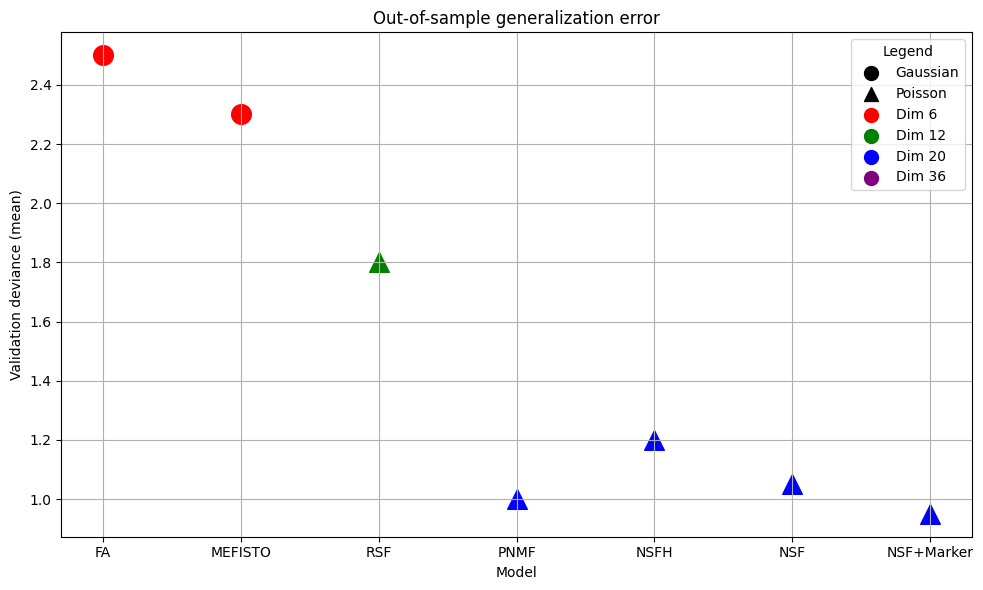

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Simulated sample data
data = {
    'Model': ['FA', 'MEFISTO', 'RSF', 'PNMF', 'NSFH', 'NSF', 'NSF+Marker'],
    'Deviance': [2.5, 2.3, 1.8, 1.0, 1.2, 1.05, 0.95],
    'Dim': [6, 6, 12, 20, 20, 20, 20],
    'Likelihood': ['Gaussian', 'Gaussian', 'Poisson', 'Poisson', 'Poisson', 'Poisson', 'Poisson']
}

df = pd.DataFrame(data)
shapes = {'Gaussian': 'o', 'Poisson': '^'}
palette = {6: 'red', 12: 'green', 20: 'blue', 36: 'purple'}

fig, ax = plt.subplots(figsize=(10, 6))
for _, row in df.iterrows():
    ax.scatter(
        row['Model'], row['Deviance'],
        marker=shapes[row['Likelihood']],
        color=palette[row['Dim']],
        s=200  # size
    )

# Custom legend
for lik, shape in shapes.items():
    ax.scatter([], [], marker=shape, label=lik, color='k', s=100)
for dim, color in palette.items():
    ax.scatter([], [], marker='o', label=f'Dim {dim}', color=color, s=100)

ax.set_ylabel('Validation deviance (mean)')
ax.set_xlabel('Model')
ax.set_title('Out-of-sample generalization error')
ax.legend(title='Legend')
plt.grid(True)
plt.tight_layout()
plt.show()

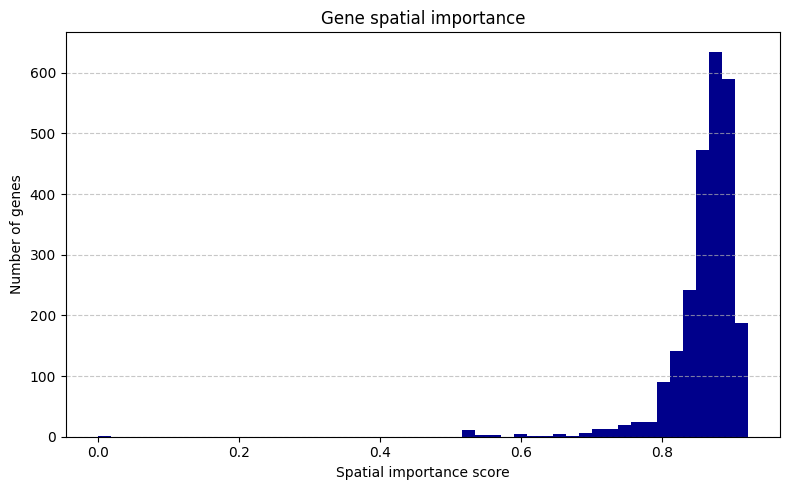

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Load the marker similarity matrix
similarity_matrix = np.load("C:/Users/vaibh/Downloads/Kernel_Proj/nsf-paper/marker_similarity.npy")

# Compute spatial importance score per gene
# We use the average similarity of each gene to all others
spatial_importance_scores = similarity_matrix.mean(axis=1)

# Plot similar to Fig. 5b: Gene spatial importance histogram
plt.figure(figsize=(8, 5))
plt.hist(spatial_importance_scores, bins=50, color='darkblue')
plt.xlabel("Spatial importance score")
plt.ylabel("Number of genes")
plt.title("Gene spatial importance")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

# Step 1: Get gene expression matrix
Y = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
Y = np.log1p(Y)  # ✅ Fix 1: Log-transform gene expression

# Step 2: Compute PCA if not already present
X_pca = PCA(n_components=8).fit_transform(Y)  # Reduce to 8 dims like original

# Step 3: Sample latent spatial factors from model
F_samples = model.sample_latent_GP_funcs(X=X_pca, S=10)  # shape: (10, L, N)
F_mean = np.mean(F_samples, axis=0).T  # (N, L)

# Step 4: Take only spatial components
F_spatial = F_mean[:, :10]  # (N, L_spatial)

# Fix 3: Get and center W_spatial
W_full = model.W.numpy()  # shape: (G, L), so we must transpose
print("W_full shape before transpose: ", W_full.shape)

W_full = W_full.T  # now shape is (L, G)
print("W_full shape after transpose: ", W_full.shape)

W_spatial = W_full[:10, :]  # shape: (10, G)
print("W_spatial shape: ", W_spatial.shape)

W_spatial = W_spatial - W_spatial.mean(axis=1, keepdims=True)

# Step 5: Reconstruct expression using spatial factors
Y_spatial_hat = F_spatial @ W_spatial  # (N x G)
print("Y_spatial_hat shape: ", Y_spatial_hat.shape)

# Fix 4: Apply rescaling transform per gene
Y_spatial_hat_rescaled = np.zeros_like(Y_spatial_hat)
for g in range(Y.shape[1]):
    reg = LinearRegression().fit(Y_spatial_hat[:, [g]], Y[:, g])
    Y_spatial_hat_rescaled[:, g] = reg.predict(Y_spatial_hat[:, [g]])

# Step 6: Compute R² per gene
spatial_scores = np.array([
    r2_score(Y[:, g], Y_spatial_hat_rescaled[:, g]) for g in range(Y.shape[1])
])

# Step 7: Save result
np.save("C:/Users/vaibh/Downloads/Kernel_Proj/nsf-paper/spatial_scores_marker_nsf.npy", spatial_scores)
print("✅ spatial_scores_marker_nsf.npy saved successfully.")

K_marker shape: [1 10 100 100]
Mask shape used: [100 100]
K_marker shape: [1 10 100 100]
Mask shape used: [100 100]
Kuu_chol shape: [1 10 100 100]
Kuu_chol shape: [10 100 100]
K_marker shape: [1 10 100 2487]
Mask shape used: [100 100]
K_marker shape: [1 10 100 2487]
Mask shape used: [100 100]
Kuf shape: [10 100 2487]
K_marker shape: [1 10 2487 2487]
Mask shape used: [100 100]
K_marker shape: [1 10 2487 2487]
Mask shape used: [100 100]
alpha_x shape: [10 100 2487]
Kff_diag shape: [10 2487]
aKa shape: [10 2487]
aOmega_a shape: [10 2487]
W_full shape before transpose:  (2000, 10)
W_full shape after transpose:  (10, 2000)
W_spatial shape:  (10, 2000)
Y_spatial_hat shape:  (2487, 2000)
✅ spatial_scores_marker_nsf.npy saved successfully.


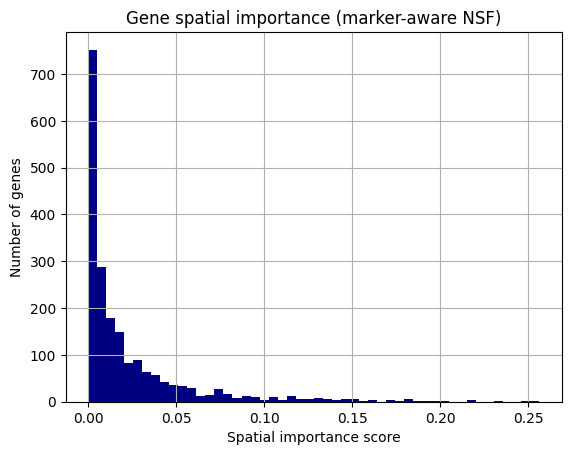

In [10]:
import matplotlib.pyplot as plt

plt.hist(spatial_scores, bins=50, color="navy")
plt.xlabel("Spatial importance score")
plt.ylabel("Number of genes")
plt.title("Gene spatial importance (marker-aware NSF)")
plt.grid(True)
plt.show()

In [ ]:
import importlib
import models.sf
importlib.reload(models.sf)
import utils.training
importlib.reload(utils.training)
import tensorflow as tf
import tensorflow_probability as tfp
import scanpy as sc
import numpy as np
from sklearn.neighbors import NearestNeighbors
from models.sf import SpatialFactorization
from utils.training import ModelTrainer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from utils import benchmark

marker_genes = [
    "Slc17a7",  # Excitatory neurons
    "Gad1",     # Inhibitory neurons
    "Aqp4",     # Astrocytes
    "Pvalb",    # Parvalbumin interneurons
    "Sst",      # Somatostatin interneurons
    "Mog"       # Oligodendrocytes
]
scaler = StandardScaler()
adata = sc.read("C:/Users/vaibh/Downloads/Kernel_Proj/nsf-paper/scrna/visium_brain_sagittal/data/visium_brain_sagittal_J2000.h5ad")
marker_expr = adata[:, marker_genes].X.toarray()  # Convert to dense (N x K)
marker_expr = marker_expr.astype(np.float32)
spatial_coords = adata.obsm["spatial"]  # N x 2 matrix (x, y coordinates)
X_augmented = np.hstack([spatial_coords, marker_expr])  # N x (2 + K)
X_augmented = scaler.fit_transform(X_augmented).astype(np.float32)
#X_augmented = X_augmented.astype(np.float32)

def generate_marker_ml_pairs(marker_expr, n_neighbors=2):
    """Generate ML pairs using k-NN on marker expressions."""
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(marker_expr)
    _, indices = nbrs.kneighbors(marker_expr)
    ml_ind1 = np.repeat(np.arange(marker_expr.shape[0]), n_neighbors)
    ml_ind2 = indices.flatten()
    return ml_ind1, ml_ind2

ml_ind1, ml_ind2 = generate_marker_ml_pairs(marker_expr, n_neighbors=2)

dataset_dict = {
    "X": X_augmented,
    "Y": adata.X.toarray(),  # Ensure dense matrix
    "sz": np.ones(adata.n_obs, dtype=np.float32)  # Size factors (adjust if needed)
}

Dtrain = tf.data.Dataset.from_tensor_slices(dataset_dict).batch(256)
kmeans = KMeans(n_clusters=100, random_state=42).fit(X_augmented)
Z_init = kmeans.cluster_centers_.astype(np.float32)
# Initialize model with augmented dimensions
model = SpatialFactorization(
    J=adata.n_vars,
    L=10,  # Number of latent factors
    Z=Z_init,  # Use first 100 cells as inducing points
    ml_weight=100, # Initialize the model (for example, with any required args including ml_weight if needed)
    nonneg=True,
    isotropic=False,
    marker_dim=6,
    psd_kernel=tfp.math.psd_kernels.MaternThreeHalves,
    nugget=1e-2  # ✅ Increase to something like 1e-3 or 1e-2
)

# Set the global must-link constraints in the model
model.set_marker_constraints(ml_ind1, ml_ind2)

# Initialize trainer
trainer = ModelTrainer(model, lr=0.01, pickle_path=None)
trainer_marker = trainer
# Train
trainer_marker.train_model(
    Dtrain=Dtrain,
    Ntr=adata.n_obs,
    num_epochs=1000,
    ckpt_freq=50,
    verbose=True
)

In [31]:
# Standard NSF with Matern 1/2 Kernel
from models.sf import SpatialFactorization
from utils.training import ModelTrainer
from utils import benchmark

adata = sc.read("C:/Users/vaibh/Downloads/Kernel_Proj/nsf-paper/scrna/visium_brain_sagittal/data/visium_brain_sagittal_J2000.h5ad")

# Reload and setup
Z_init = kmeans.cluster_centers_.astype(np.float32)

model_baseline = SpatialFactorization(
    J=adata.n_vars,
    L=10,
    Z=Z_init,
    ml_weight=0,
    nonneg=True,
    isotropic=False,
    marker_dim=6,  # Not needed
    psd_kernel=tfp.math.psd_kernels.MaternOneHalf,
    nugget=1e-2
)

trainer_baseline = ModelTrainer(model_baseline, lr=0.01, pickle_path=None)

trainer_baseline.train_model(
    Dtrain=Dtrain,
    Ntr=adata.n_obs,
    num_epochs=1000,
    ckpt_freq=50,
    verbose=True
)

Temporary checkpoint directory: C:\Users\vaibh\AppData\Local\Temp\tmps5id9heq
0010 train: 2.771e+03
0020 train: 2.637e+03
0030 train: 2.617e+03
0040 train: 2.601e+03
0050 train: 2.593e+03
0060 train: 2.585e+03
0070 train: 2.583e+03
0080 train: 2.572e+03
0090 train: 2.579e+03
0100 train: 2.573e+03
0110 train: 2.589e+03, chg: 5.09e-04
0120 train: 2.578e+03, chg: 1.46e-04
0130 train: 2.586e+03, chg: -2.37e-05
0140 train: 2.583e+03, chg: 2.30e-06
0140 training complete, converged.


Expected training rows: 1990
Expected validation rows: 497
Available augmented rows: 2487


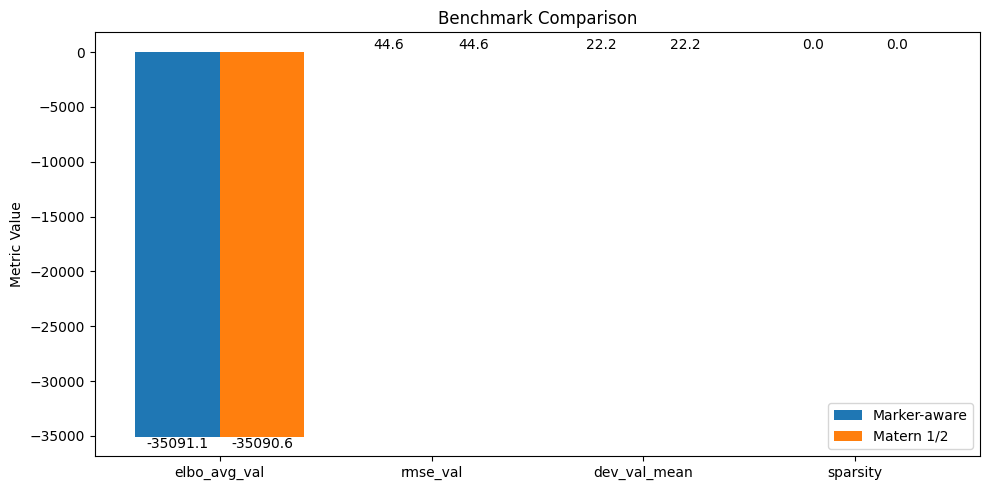

In [37]:
from utils.preprocess import load_data
from utils.benchmark import get_metrics
from utils.visualize import gof
import matplotlib.pyplot as plt
import pandas as pd

# Load the data using default options for Poisson likelihood
D, fmeans = load_data(
    "C:/Users/vaibh/Downloads/Kernel_Proj/nsf-paper/scrna/visium_brain_sagittal/data/visium_brain_sagittal_J2000.h5ad",
    model="NSF",  # Your model type
    lik="poi",    # Likelihood: poisson
    sz="constant",
    train_frac=0.8
)

trainer_marker.elbos = trainer_marker.loss["train"]
trainer_baseline.elbos = trainer_baseline.loss["train"]
# Add required attributes for benchmarking
trainer_marker.model.converged = True
trainer_marker.model.epoch = trainer_marker.epoch
trainer_marker.model.ptime = trainer_marker.ptime
trainer_marker.model.wtime = trainer_marker.wtime
trainer_marker.model.elbos = trainer_marker.loss["train"]

trainer_baseline.model.converged = True
trainer_baseline.model.epoch = trainer_baseline.epoch
trainer_baseline.model.ptime = trainer_baseline.ptime
trainer_baseline.model.wtime = trainer_baseline.wtime
trainer_baseline.model.elbos = trainer_baseline.loss["train"]

# Reconstruct full augmented features (standardized) for the full dataset
X_augmented_full = np.hstack([spatial_coords, marker_expr])
X_augmented_full = scaler.transform(X_augmented_full).astype(np.float32)

# Get number of training samples
Ntr = D["raw"]["tr"]["X"].shape[0]
Nval = D["raw"]["val"]["X"].shape[0]

# Reassign X values directly from split
D["raw"]["tr"]["X"] = tf.convert_to_tensor(X_augmented_full[:Ntr])
D["raw"]["val"]["X"] = tf.convert_to_tensor(X_augmented_full[Ntr:Ntr+Nval])
print("Expected training rows:", D["raw"]["tr"]["X"].shape[0])
print("Expected validation rows:", D["raw"]["val"]["X"].shape[0])
print("Available augmented rows:", X_augmented_full.shape[0])


# Marker-aware kernel model
res_marker = get_metrics(trainer_marker.model, D["raw"]["tr"], Dval=D["raw"]["val"])

# Standard NSF model with Matern 1/2 kernel
res_baseline = get_metrics(trainer_baseline.model, D["raw"]["tr"], Dval=D["raw"]["val"])

res_marker["elbo_avg_val"] = -trainer_marker.model.validation_step(D["raw"]["val"], S=10).numpy()
res_baseline["elbo_avg_val"] = -trainer_baseline.model.validation_step(D["raw"]["val"], S=10).numpy()


def plot_comparison(res1, res2, labels=["Marker-aware", "Matern 1/2"]):
    metrics = ["elbo_avg_val", "rmse_val", "dev_val_mean", "sparsity"]
    x = range(len(metrics))
    vals1 = [res1[m] for m in metrics]
    vals2 = [res2[m] for m in metrics]

    plt.figure(figsize=(10, 5))
    bars1 = plt.bar([i - 0.2 for i in x], vals1, width=0.4, label=labels[0])
    bars2 = plt.bar([i + 0.2 for i in x], vals2, width=0.4, label=labels[1])

    for bar in bars1 + bars2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 f"{height:.1f}", ha='center', va='bottom' if height > 0 else 'top')

    plt.xticks(x, metrics)
    plt.ylabel("Metric Value")
    plt.title("Benchmark Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_comparison(res_marker, res_baseline)
#df = pd.DataFrame([res_marker, res_baseline], index=["Marker-aware", "Matern 1/2"])
#df.to_csv("C:/Users/vaibh/Downloads/Kernel_Proj/nsf_comparison_results.csv")

In [39]:
import pandas as pd

df = pd.DataFrame([res_marker, res_baseline], index=["Marker-aware", "Matern 1/2"])
print(df[["elbo_avg_val", "rmse_val", "dev_val_mean", "sparsity"]])

              elbo_avg_val   rmse_val  dev_val_mean  sparsity
Marker-aware -35091.066406  44.625702     22.180523    0.0039
Matern 1/2   -35090.570312  44.624813     22.172070    0.0037


Input shape to kernel: (2487, 8)


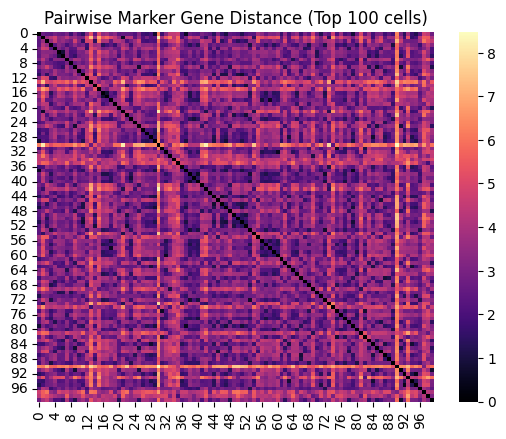

In [47]:
print("Input shape to kernel:", X_augmented_full.shape)
from scipy.spatial.distance import pdist, squareform
D_marker = squareform(pdist(marker_expr[:100], metric='euclidean'))

sns.heatmap(D_marker, cmap='magma')
plt.title("Pairwise Marker Gene Distance (Top 100 cells)")
plt.show()
